# GRANIT SINIFLANDIRMA
Bu çalışmada,
* BLUPER
* KREMEPELLA
* MISIR
* ROSAMINO
* ROSAPORINO
* STAR_GALAXY

olmak üzere altı granit taş türü bulunmaktadır. Bazı modelleri kullanılarak Granit taşlarının sınıflandırılması amaçlanmıştır. 



---

## Drive'ın Mount Edilmesi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* Gerekli kütüphanelerin import edilmesi.
* Train, test ve validation veri kümelerinin çekilmesi ve gerekli ön işlemlerin yapılarak oluşturulması.
* Veri setinden birkaç örnek resim sunulması.

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.chdir("/content/drive/MyDrive/EklemeliStones")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.applications import InceptionV3 , mobilenet,mobilenet_v2
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from keras.applications import EfficientNetB2,EfficientNetB3,EfficientNetB5
from keras.preprocessing.image import ImageDataGenerator
from keras import Model 
from keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D,BatchNormalization
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.applications import resnet
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn import metrics

from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

import seaborn as sns
sns.set_style('darkgrid')

Found 3342 images belonging to 6 classes.
Found 417 images belonging to 6 classes.
Found 417 images belonging to 6 classes.


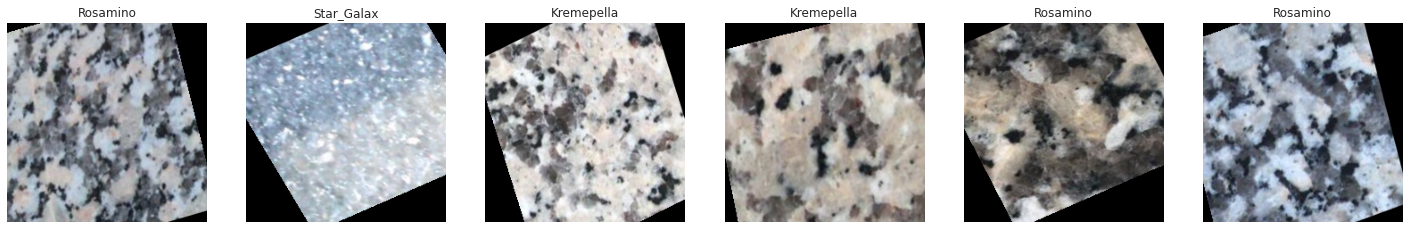

In [ ]:
EPOCHS = 10
train_data_gen = ImageDataGenerator(rotation_range=30,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)
valid_data_gen = ImageDataGenerator(rotation_range=35,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)

test_data_gen = ImageDataGenerator(rescale=1./255)

dataset_dir = '/content/drive/MyDrive/EklemeliStones/train'
valid_dr = '/content/drive/MyDrive/EklemeliStones/valid_Granit'
test_dr = '/content/drive/MyDrive/EklemeliStones/test_Granit'


Batch_size = 32
img_h = 224
img_w = 224
num_classes=6
classes = ['BLUPER','KREMEPELLA', 'MISIR','ROSAMINO', 'ROSAPORINO','STAR_GALAXY']


# Training
SEED = 1234
tf.random.set_seed(SEED) 


train_gen = train_data_gen.flow_from_directory(dataset_dir,
                                               target_size=(224, 224),
                                               batch_size=Batch_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED)  # targets are directly converted into one-hot vectors

# Validation
valid_gen = valid_data_gen.flow_from_directory(valid_dr,
                                           target_size=(224, 224),
                                           batch_size=Batch_size, 
                                           classes=classes,
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed=SEED)

test_gen = test_data_gen.flow_from_directory(test_dr,
                                             target_size=(224, 224),
                                             batch_size=1, 
                                             shuffle=False,
                                             seed=SEED,
                                             class_mode=None,
                                             )

class_names = np.array(['BLUPER','KREMEPELLA', 'MISIR','ROSAMINO', 'ROSAPORINO','STAR_GALAXY'], dtype='<U10')



def show_batch(image_batch, label_batch):
  plt.figure(figsize=(25,20))
  
  for n in range(0,6):
      ax = plt.subplot(1,6,n+1)
      plt.imshow(image_batch[n])
      plt.title(class_names[label_batch[n]==True][0].title())
      plt.axis('off')
      
image_batch, label_batch = next(train_gen)
show_batch(image_batch, label_batch)

In [ ]:
def cm_cr(test_gen, model):
    preds=model.predict(test_gen)    
    labels=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    pred_list=[ ] 
    true_list=[]
    for i, p in enumerate (preds):
        index=np.argmax(p)
        pred_list.append(classes[index])
        true_list.append(classes[labels[i]])
    y_pred=np.array(pred_list)
    y_true=np.array(true_list)
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)
    cm = confusion_matrix(y_true, y_pred )        
    length=len(classes)
    if length<8:
        fig_width=8
        fig_height=8
    else:
        fig_width= int(length * .5)
        fig_height= int(length * .5)
    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(length)+.5, classes, rotation= 90, fontsize=16)
    plt.yticks(np.arange(length)+.5, classes, rotation=0, fontsize=16)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
def scoreGraph(history):
  print(history.history.keys())
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [ ]:
def roc_auc(test_gen,model):
  STEP_SIZE_TEST  = test_gen.n//test_gen.batch_size
  y_pred_keras = model.predict_generator(test_gen, steps=STEP_SIZE_TEST, verbose=1)
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_gen.classes, y_pred_keras[:,1], pos_label=1)
  auc_keras = auc(fpr_keras, tpr_keras)
  print("AUC : ",auc_keras)
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()

# ResNet50 MODELİ
* Modelin yüklenmesi yapılmaktadır. 
* Modelin oluşturulması.
* Modelin derlenmesi.
* ResNet Modeli ile veri kümesinin eğitilmesi.

In [ ]:
def RESNET50():
  # ALTTAKİ SATIRA weights='imagenet' EKLENEREK TRANSFER ÖĞRENME YAPILABİLİR. 
  # DİĞERLERİNE UYGULADIM. 
  resnet50_base = resnet.ResNet50(include_top=False, input_tensor=None, input_shape=(img_h, img_w,3))

  tf.keras.layers.Rescaling(1./255)
  output = resnet50_base.get_layer(index = -1).output  
  output = Flatten()(output)
  output = Dense(512,activation = "relu")(output)
  output = BatchNormalization()(output)
  output = Dropout(0.2)(output)
  output = Dense(512,activation = "relu")(output)
  output = BatchNormalization()(output)
  output = Dropout(0.2)(output)
  output = Dense(6, activation='softmax')(output)
  resnet50_model = Model(resnet50_base.input, output)
  for layer in resnet50_model.layers[:-7]:
      layer.trainable = False
  resnet50_model.summary()
  print(len(resnet50_model.layers))
  resnet50_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics =['accuracy'])

  callbacks = EarlyStopping(monitor='val_loss', patience=4, verbose=2, mode='auto')
  reduce_lr = ReduceLROnPlateau(patience=5, monitor='val_acc', factor=0.1, min_lr=0.0000001, mode='auto', verbose=2) #min_lr=0.0000001

  STEP_SIZE_TRAIN = train_gen.n//train_gen.batch_size
  STEP_SIZE_VALID = valid_gen.n//valid_gen.batch_size
  STEP_SIZE_TEST  = test_gen.n//test_gen.batch_size
  
  transfer_learning_history = resnet50_model.fit_generator(generator=train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_gen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS, callbacks = [callbacks]
                      )        
  
  resnet50_model.save("/content/drive/MyDrive/EklemeliStones/cimstone_resnet50.h5")  
  # VAROLAN EĞİTİLMİŞ BİR MODEL YÜKLENMEK İSTENİRSE
  #from keras.models import load_model
  #model_new = load_model("/content/drive/MyDrive/EklemeliStones/cimstone_resnet50.h5")
  #model_new.evaluate(valid_gen, steps=valid_gen.n//valid_gen.batch_size,verbose=1)
  #pred = model_new.predict(test_gen,steps=test_gen.n//valid_gen.batch_size,verbose=1)     
  # MEVCUT YUKARIDA EĞİTİLEN MODEL İLE DEVAM ETMEK İSTENİRSE
  resnet50_model.evaluate(valid_gen, steps=valid_gen.n//valid_gen.batch_size,verbose=1)
  pred = resnet50_model.predict(test_gen,steps=test_gen.n//valid_gen.batch_size,verbose=1)
  # YENİ EĞİTİLEN MODELİN HISTORYSİNE BAKARAK GRAFİK OLUŞTURULUR.
  scoreGraph(transfer_learning_history)
  cm_cr(test_gen, resnet50_model)
  roc_auc(test_gen, resnet50_model)
        

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

<ipython-input-7-cb45e05ea25b>:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  transfer_learning_history = resnet50_model.fit_generator(generator=train_gen,


Epoch 1/10
104/104 [==============================] - 1087s 10s/step - loss: 1.5577 - accuracy: 0.4353 - val_loss: 18.1399 - val_accuracy: 0.2380
Epoch 2/10
104/104 [==============================] - 53s 509ms/step - loss: 1.2120 - accuracy: 0.5417 - val_loss: 47.2702 - val_accuracy: 0.2380
Epoch 3/10
104/104 [==============================] - 56s 535ms/step - loss: 1.1201 - accuracy: 0.5692 - val_loss: 3.6696 - val_accuracy: 0.3654
Epoch 4/10
104/104 [==============================] - 58s 553ms/step - loss: 1.0663 - accuracy: 0.5719 - val_loss: 4.6336 - val_accuracy: 0.2644
Epoch 5/10
104/104 [==============================] - 56s 540ms/step - loss: 1.0098 - accuracy: 0.5943 - val_loss: 3.4444 - val_accuracy: 0.4375
Epoch 6/10
104/104 [==============================] - 55s 530ms/step - loss: 0.9824 - accuracy: 0.6115 - val_loss: 2.7488 - val_accuracy: 0.4038
Epoch 7/10
104/104 [==============================] - 52s 496ms/step - loss: 0.9545 - accuracy: 0.6278 - val_loss: 1.9625 - val_

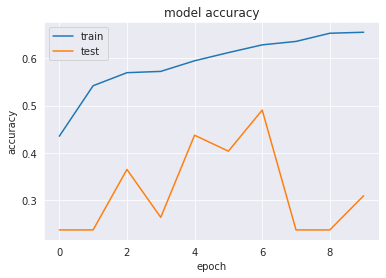

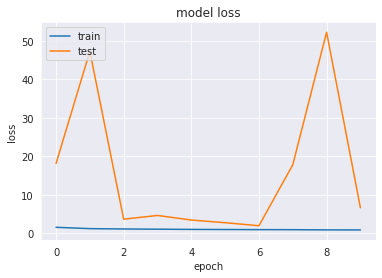

417/417 [==============================] - 146s 352ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
----------------------
               precision    recall  f1-score   support

      BLUPER       0.00      0.00      0.00        43
  KREMEPELLA       0.14      0.86      0.23        50
       MISIR       0.00      0.00      0.00        99
    ROSAMINO       0.00      0.00      0.00        93
  ROSAPORINO       0.00      0.00      0.00        48
 STAR_GALAXY       0.85      1.00      0.92        84

    accuracy                           0.30       417
   macro avg       0.16      0.31      0.19       417
weighted avg       0.19      0.30      0.21       417



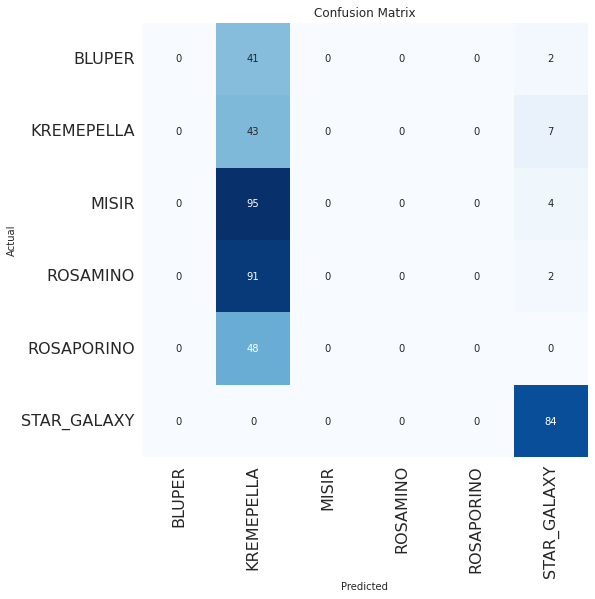

  5/417 [..............................] - ETA: 6s 

<ipython-input-6-8b09217d3068>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_keras = model.predict_generator(test_gen, steps=STEP_SIZE_TEST, verbose=1)


417/417 [==============================] - 7s 17ms/step
AUC :  0.46670299727520437


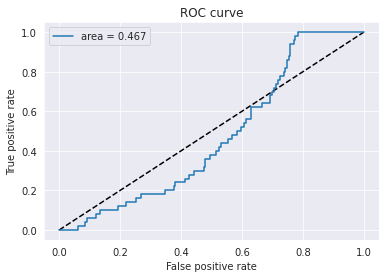

In [ ]:
RESNET50()

# VGG16 MODELİ
* Train, test ve validation veri kümelerinin çekilmesi ve gerekli ön işlemlerin yapılarak oluşturulması.
* VGG modelinin yüklenmesi ve modelin oluşturulması. 
* Modelin derlenip, veri kümesi üzerinde eğitilmesi.

In [ ]:
def VirtualGG16():
  vgg16_base = VGG16(include_top=False, input_tensor=None,weights='imagenet', input_shape=(img_h, img_w,3))

  output = vgg16_base.get_layer(index = -1).output  
  output = Flatten()(output)
  # let's add a fully-connected layer
  output = Dense(1024,activation = "relu")(output)
  output = BatchNormalization()(output)
  output = Dropout(0.2)(output)
  output = Dense(1024,activation = "relu")(output)
  output = BatchNormalization()(output)
  output = Dropout(0.2)(output)
  output = Dense(6, activation='softmax')(output)
  vgg16_model = Model(vgg16_base.input, output)
  for layer in vgg16_model.layers[:-7]:
      layer.trainable = False
  vgg16_model.summary()
  vgg16_model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics =['accuracy'])

  callbacks = EarlyStopping(monitor='val_loss', patience=4, verbose=2, mode='auto')
  reduce_lr = ReduceLROnPlateau(patience=5, monitor='val_acc', factor=0.1, min_lr=0.0000001, mode='auto', verbose=2) #min_lr=0.0000001

  STEP_SIZE_TRAIN = train_gen.n//train_gen.batch_size
  STEP_SIZE_VALID = valid_gen.n//valid_gen.batch_size
  STEP_SIZE_TEST  = test_gen.n//test_gen.batch_size


  history = vgg16_model.fit_generator(train_gen,
                                epochs=EPOCHS,
                                verbose=1,
                                validation_data=valid_gen,
                                callbacks = [callbacks]
                                )

  vgg16_model.save("/content/drive/MyDrive/EklemeliStones/cimstone_vgg16.h5")  
  # VAROLAN EĞİTİLMİŞ BİR MODEL YÜKLENMEK İSTENİRSE
  #from keras.models import load_model
  #model_new = load_model("/content/drive/MyDrive/EklemeliStones/cimstone_vgg16.h5")
  #model_new.evaluate(valid_gen, steps=valid_gen.n//valid_gen.batch_size,verbose=1)
  #pred = model_new.predict(test_gen,steps=test_gen.n//valid_gen.batch_size,verbose=1)     
  # MEVCUT YUKARIDA EĞİTİLEN MODEL İLE DEVAM ETMEK İSTENİRSE
  vgg16_model.evaluate(valid_gen, steps=valid_gen.n//valid_gen.batch_size,verbose=1)
  pred = vgg16_model.predict(test_gen,steps=test_gen.n//valid_gen.batch_size,verbose=1)
  # YENİ EĞİTİLEN MODELİN HISTORYSİNE BAKARAK GRAFİK OLUŞTURULUR.
  scoreGraph(history)
  cm_cr(test_gen, vgg16_model)
  roc_auc(test_gen, vgg16_model)

58889256/58889256 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

<ipython-input-9-954ac79770ca>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = vgg16_model.fit_generator(train_gen,


Epoch 1/10
105/105 [==============================] - 60s 520ms/step - loss: 0.7316 - accuracy: 0.7789 - val_loss: 2.3336 - val_accuracy: 0.6427
Epoch 2/10
105/105 [==============================] - 52s 497ms/step - loss: 0.3997 - accuracy: 0.8567 - val_loss: 0.5043 - val_accuracy: 0.8153
Epoch 3/10
105/105 [==============================] - 52s 495ms/step - loss: 0.3320 - accuracy: 0.8827 - val_loss: 0.3258 - val_accuracy: 0.8873
Epoch 4/10
105/105 [==============================] - 56s 533ms/step - loss: 0.2845 - accuracy: 0.8971 - val_loss: 0.3466 - val_accuracy: 0.8897
Epoch 5/10
105/105 [==============================] - 51s 486ms/step - loss: 0.2327 - accuracy: 0.9171 - val_loss: 0.2689 - val_accuracy: 0.8945
Epoch 6/10
105/105 [==============================] - 55s 528ms/step - loss: 0.2229 - accuracy: 0.9204 - val_loss: 0.3997 - val_accuracy: 0.8873
Epoch 7/10
105/105 [==============================] - 52s 493ms/step - loss: 0.2113 - accuracy: 0.9204 - val_loss: 0.9331 - val_ac

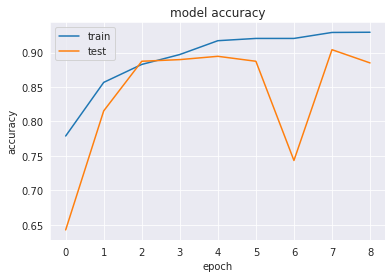

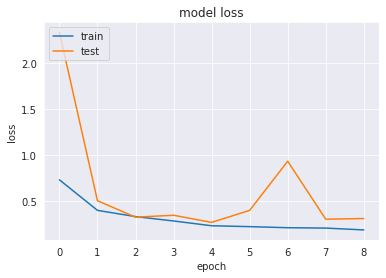

417/417 [==============================] - 4s 10ms/step
Classification Report:
----------------------
               precision    recall  f1-score   support

      BLUPER       1.00      1.00      1.00        43
  KREMEPELLA       0.67      0.90      0.77        50
       MISIR       0.97      0.96      0.96        99
    ROSAMINO       0.95      0.82      0.88        93
  ROSAPORINO       0.91      0.88      0.89        48
 STAR_GALAXY       1.00      0.99      0.99        84

    accuracy                           0.92       417
   macro avg       0.92      0.92      0.92       417
weighted avg       0.93      0.92      0.92       417



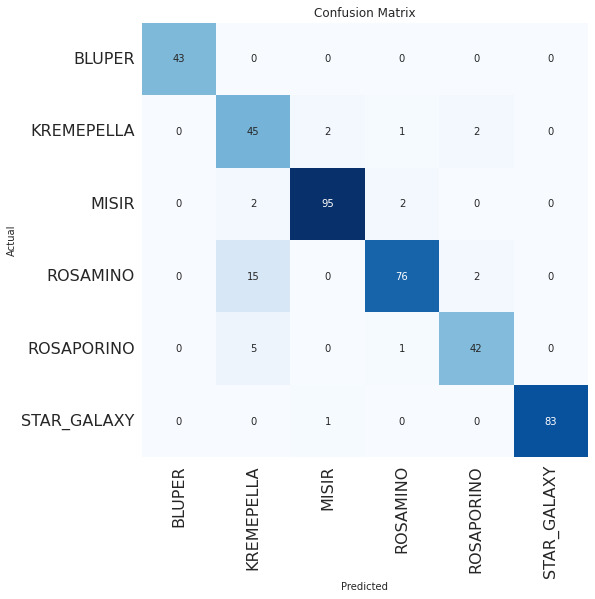

 13/417 [..............................] - ETA: 3s

<ipython-input-6-8b09217d3068>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_keras = model.predict_generator(test_gen, steps=STEP_SIZE_TEST, verbose=1)


417/417 [==============================] - 4s 10ms/step
AUC :  0.9743869209809264


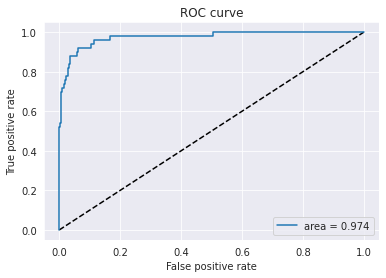

In [ ]:
VirtualGG16()

# INCEPTION MODELİ
* Modelin yüklenmesi ve oluşturulması.
* Modelin derlenmesi ve veri kümesi üzerinde modelin eğitilmesi.

In [ ]:
def INCEPTIONV3():

  inception_model = InceptionV3(include_top=False, input_tensor=None,weights='imagenet', input_shape=(img_h, img_w,3))

  output = inception_model.get_layer(index = -1).output  
  output = Flatten()(output)
  # let's add a fully-connected layer
  output = Dense(1024,activation = "relu")(output)
  output = BatchNormalization()(output)
  output = Dropout(0.2)(output)
  output = Dense(1024,activation = "relu")(output)
  output = BatchNormalization()(output)
  output = Dropout(0.2)(output)
  output = Dense(6, activation='softmax')(output)
  inception_model = Model(inception_model.input, output)
  for layer in inception_model.layers[:-7]:
      layer.trainable = False
  inception_model.summary()
  inception_model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics =['accuracy'])

  callbacks = EarlyStopping(monitor='val_loss', patience=4, verbose=2, mode='auto')
  reduce_lr = ReduceLROnPlateau(patience=5, monitor='val_acc', factor=0.1, min_lr=0.0000001, mode='auto', verbose=2) #min_lr=0.0000001

  STEP_SIZE_TRAIN = train_gen.n//train_gen.batch_size
  STEP_SIZE_VALID = valid_gen.n//valid_gen.batch_size
  STEP_SIZE_TEST  = test_gen.n//test_gen.batch_size

  history = inception_model.fit_generator(train_gen,
                                epochs=EPOCHS,
                                verbose=1,
                                validation_data=valid_gen,
                                callbacks = [callbacks]
                                )
  inception_model.save("/content/drive/MyDrive/EklemeliStones/cimstone_inception.h5")  
  # VAROLAN EĞİTİLMİŞ BİR MODEL YÜKLENMEK İSTENİRSE
  #from keras.models import load_model
  #model_new = load_model("/content/drive/MyDrive/EklemeliStones/cimstone_inception.h5")
  #model_new.evaluate(valid_gen, steps=valid_gen.n//valid_gen.batch_size,verbose=1)
  #pred = model_new.predict(test_gen,steps=test_gen.n//valid_gen.batch_size,verbose=1)     
  # MEVCUT YUKARIDA EĞİTİLEN MODEL İLE DEVAM ETMEK İSTENİRSE
  inception_model.evaluate(valid_gen, steps=valid_gen.n//valid_gen.batch_size,verbose=1)
  pred = inception_model.predict(test_gen,steps=test_gen.n//valid_gen.batch_size,verbose=1)
  # YENİ EĞİTİLEN MODELİN HISTORYSİNE BAKARAK GRAFİK OLUŞTURULUR.
  scoreGraph(history)
  cm_cr(test_gen, inception_model)
  roc_auc(test_gen, inception_model)
      

87910968/87910968 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 rmalization)              

<ipython-input-11-556fa282c608>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = inception_model.fit_generator(train_gen,


Epoch 1/10
105/105 [==============================] - 66s 542ms/step - loss: 0.7679 - accuracy: 0.7720 - val_loss: 1.0929 - val_accuracy: 0.8034
Epoch 2/10
105/105 [==============================] - 55s 520ms/step - loss: 0.4366 - accuracy: 0.8453 - val_loss: 0.5469 - val_accuracy: 0.8393
Epoch 3/10
105/105 [==============================] - 50s 481ms/step - loss: 0.3110 - accuracy: 0.8866 - val_loss: 0.4337 - val_accuracy: 0.8681
Epoch 4/10
105/105 [==============================] - 49s 469ms/step - loss: 0.2905 - accuracy: 0.8983 - val_loss: 0.3268 - val_accuracy: 0.8801
Epoch 5/10
105/105 [==============================] - 50s 478ms/step - loss: 0.2658 - accuracy: 0.9004 - val_loss: 0.3165 - val_accuracy: 0.8849
Epoch 6/10
105/105 [==============================] - 51s 482ms/step - loss: 0.2618 - accuracy: 0.8977 - val_loss: 0.2867 - val_accuracy: 0.8897
Epoch 7/10
105/105 [==============================] - 49s 468ms/step - loss: 0.2599 - accuracy: 0.9087 - val_loss: 0.2274 - val_ac

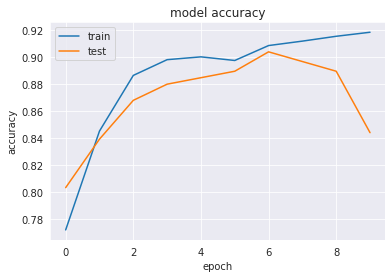

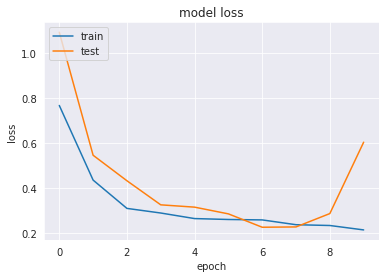

417/417 [==============================] - 10s 23ms/step
Classification Report:
----------------------
               precision    recall  f1-score   support

      BLUPER       0.90      1.00      0.95        43
  KREMEPELLA       0.94      0.34      0.50        50
       MISIR       1.00      0.94      0.97        99
    ROSAMINO       0.87      0.97      0.92        93
  ROSAPORINO       0.65      0.98      0.78        48
 STAR_GALAXY       1.00      0.99      0.99        84

    accuracy                           0.89       417
   macro avg       0.89      0.87      0.85       417
weighted avg       0.91      0.89      0.88       417



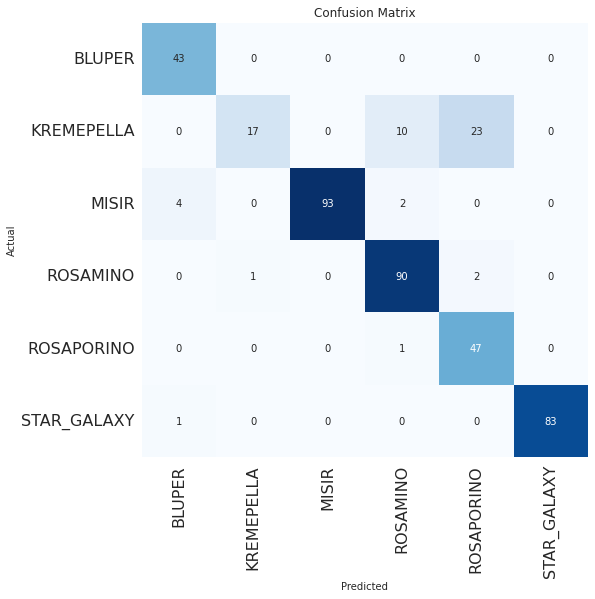

  4/417 [..............................] - ETA: 7s 

<ipython-input-6-8b09217d3068>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_keras = model.predict_generator(test_gen, steps=STEP_SIZE_TEST, verbose=1)


417/417 [==============================] - 6s 15ms/step
AUC :  0.9701362397820164


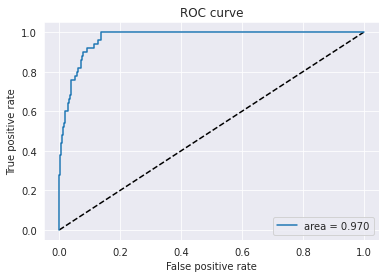

In [ ]:
INCEPTIONV3()

# EfficentNet MODELİ
* Modelin yüklenmesi ve oluşturulması.
* Modelin derlenmesi ve veri kümesi üzerinde eğitilmesi.

In [ ]:
def EFFICIENTNET():
# EfficientNet yüklemesi
  efficent_model=EfficientNetB3(include_top=False, input_tensor=None,weights='imagenet', input_shape=(img_h, img_w,3))

  output = efficent_model.get_layer(index = -1).output  
  output = Flatten()(output)
  # let's add a fully-connected layer
  output = Dense(1024,activation = "relu")(output)
  output = BatchNormalization()(output)
  output = Dropout(0.2)(output)
  output = Dense(1024,activation = "relu")(output)
  output = BatchNormalization()(output)
  output = Dropout(0.2)(output)
  output = Dense(6, activation='softmax')(output)
  efficent_model = Model(efficent_model.input, output)
  for layer in efficent_model.layers[:-7]:
      layer.trainable = False
  efficent_model.summary()
  efficent_model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics =['accuracy'])

  callbacks = EarlyStopping(monitor='val_loss', patience=4, verbose=2, mode='auto')
  reduce_lr = ReduceLROnPlateau(patience=5, monitor='val_acc', factor=0.1, min_lr=0.0000001, mode='auto', verbose=2) #min_lr=0.0000001

  STEP_SIZE_TRAIN = train_gen.n//train_gen.batch_size
  STEP_SIZE_VALID = valid_gen.n//valid_gen.batch_size
  STEP_SIZE_TEST  = test_gen.n//test_gen.batch_size


  callbacks = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')
  reduce_lr = ReduceLROnPlateau(patience=5, monitor='val_acc', factor=0.1, min_lr=0.0000001, mode='auto', verbose=1)

  history = efficent_model.fit_generator(train_gen,
                                epochs=EPOCHS,
                                verbose=1,
                                validation_data=valid_gen,
                                callbacks = [callbacks]
                                )

  efficent_model.save("/content/drive/MyDrive/EklemeliStones/cimstone_efficent.h5")  
  # VAROLAN EĞİTİLMİŞ BİR MODEL YÜKLENMEK İSTENİRSE
  #from keras.models import load_model
  #model_new = load_model("/content/drive/MyDrive/EklemeliStones/cimstone_efficent.h5")
  #model_new.evaluate(valid_gen, steps=valid_gen.n//valid_gen.batch_size,verbose=1)
  #pred = model_new.predict(test_gen,steps=test_gen.n//valid_gen.batch_size,verbose=1)     
  # MEVCUT YUKARIDA EĞİTİLEN MODEL İLE DEVAM ETMEK İSTENİRSE
  efficent_model.evaluate(valid_gen, steps=valid_gen.n//valid_gen.batch_size,verbose=1)
  pred = efficent_model.predict(test_gen,steps=test_gen.n//valid_gen.batch_size,verbose=1)
  # YENİ EĞİTİLEN MODELİN HISTORYSİNE BAKARAK GRAFİK OLUŞTURULUR.
  scoreGraph(history)
  cm_cr(test_gen, efficent_model)
  roc_auc(test_gen, efficent_model)
      

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.9.0


In [ ]:
# TF_Version hatası kronik bir keras sorunu. Çözüm için :
# https://github.com/keras-team/keras/issues/17199
"""
Got the exact same issue with TF 2.10 and TF 2.11 (tried to save model in saved_model format and in H5 format, neither worked).
Downgrading to TF2.9 helped for now but it would be really nice to be able to use TF more recent versions' features
"""
# YÜKLENDİKTEN SONRA RESTART RUNTIME YAPILMALI SADECE EFFICIENT NET ÇALIŞTIRILMALI !!!
!pip install tensorflow==2.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 48.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.1.21
    Uninstalling flatbuffers-23.1.21:
      Successfully uninstalled flatbuffers-23.1.21
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully u

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']      

<ipython-input-7-0992702cb6dc>:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = efficent_model.fit_generator(train_gen,


Epoch 1/10
105/105 [==============================] - 78s 566ms/step - loss: 2.2422 - accuracy: 0.2124 - val_loss: 18.8074 - val_accuracy: 0.2230
Epoch 2/10
105/105 [==============================] - 53s 505ms/step - loss: 1.9779 - accuracy: 0.2418 - val_loss: 16.0441 - val_accuracy: 0.1199
Epoch 3/10
105/105 [==============================] - 56s 532ms/step - loss: 1.9118 - accuracy: 0.2720 - val_loss: 2.3426 - val_accuracy: 0.3381
Epoch 4/10
105/105 [==============================] - 54s 510ms/step - loss: 1.8808 - accuracy: 0.2603 - val_loss: 7.5956 - val_accuracy: 0.1990
Epoch 5/10
105/105 [==============================] - 55s 520ms/step - loss: 1.8583 - accuracy: 0.2840 - val_loss: 1.7437 - val_accuracy: 0.2902
Epoch 6/10
105/105 [==============================] - 56s 527ms/step - loss: 1.8313 - accuracy: 0.2774 - val_loss: 3.5009 - val_accuracy: 0.1199
Epoch 7/10
105/105 [==============================] - 53s 500ms/step - loss: 1.7697 - accuracy: 0.3055 - val_loss: 1.8180 - val_

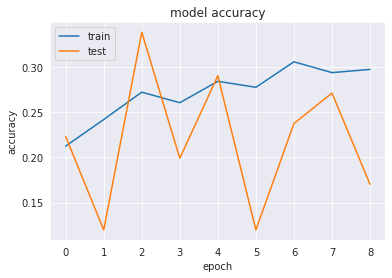

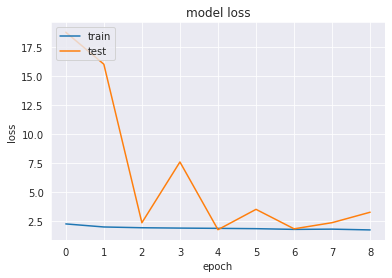

417/417 [==============================] - 352s 846ms/step
Classification Report:
----------------------
               precision    recall  f1-score   support

      BLUPER       0.00      0.00      0.00        43
  KREMEPELLA       0.00      0.00      0.00        50
       MISIR       0.00      0.00      0.00        99
    ROSAMINO       0.00      0.00      0.00        93
  ROSAPORINO       0.00      0.00      0.00        48
 STAR_GALAXY       0.20      0.96      0.33        84

    accuracy                           0.19       417
   macro avg       0.03      0.16      0.05       417
weighted avg       0.04      0.19      0.07       417



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


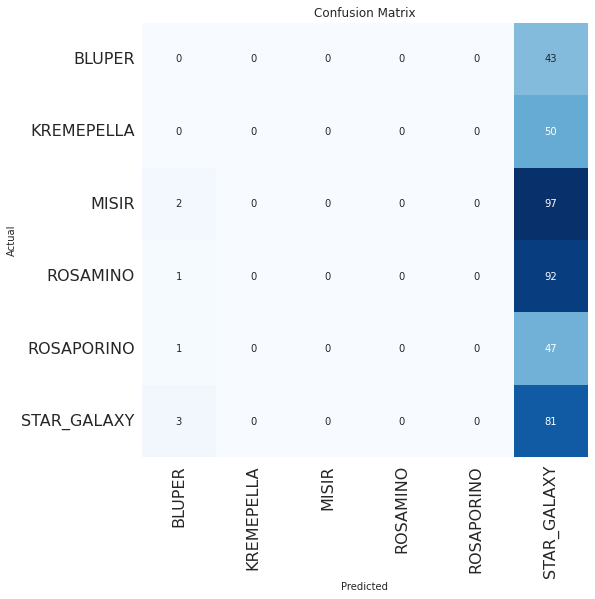

<ipython-input-6-8b09217d3068>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_keras = model.predict_generator(test_gen, steps=STEP_SIZE_TEST, verbose=1)


417/417 [==============================] - 11s 26ms/step
AUC :  0.717983651226158


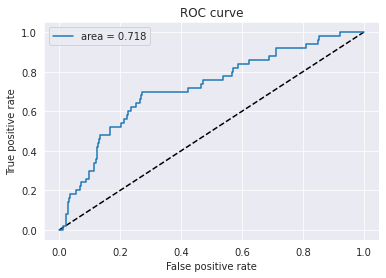

In [ ]:
EFFICIENTNET()